In [1]:
import numpy as np
import pandas as pd
import datetime

In [3]:
df = pd.read_csv('LSTM_with_PyTorch.csv')
df

,Value,Date
0,13.706000,20191202
1,14.267895,20191202
2,14.283784,20191202
3,14.054737,20191202
4,14.075263,20191202
...,...,...
3916,14.091667,20191126
3917,14.074595,20191126
3918,14.008108,20191126
3919,13.968333,20191126


Data Preparation

In [4]:
# Ordena el DataFrame por la columna 'Date' en orden ascendente
df = df.sort_values(by='Date', ascending=True)

# Convierte los valores de la columna 'Date' en objetos datetime
df['Date'] = df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d', errors='coerce'))

# Cambia el índice del DataFrame a la columna 'Date'
df.index = df['Date']

# Resamplea el DataFrame para que tenga una frecuencia diaria y toma el valor mínimo de 'Value' para cada día
df['Value'] = df.resample('D')['Value'].min()

# Elimina los duplicados del DataFrame
df = df.drop_duplicates()

# Asegura que el DataFrame tenga una frecuencia diaria, llenando las fechas faltantes
df = df.asfreq('D')

# Llena hacia adelante los valores faltantes en el DataFrame
df = df.ffill(axis=0)

# Muestra el DataFrame resultante
df


,Value,Date
Date,,
2019-11-25,13.572000,2019-11-25
2019-11-26,13.888800,2019-11-26
2019-11-27,13.010000,2019-11-27
2019-11-28,5.971053,2019-11-28
2019-11-29,12.562308,2019-11-29
...,...,...
2020-02-03,13.709474,2020-02-03
2020-02-04,13.617333,2020-02-04
2020-02-05,13.503636,2020-02-05


Data Visualisation

In [5]:
import plotly.graph_objects as go


In [6]:
# Crea un gráfico de dispersión (Scatter plot) usando Plotly
trace1 = go.Scatter(
    x = df.index,      # Establece los valores del eje x como el índice del DataFrame, que es la columna 'Date'
    y = df['Value'],   # Establece los valores del eje y como la columna 'Value' del DataFrame
    mode='lines',      # Configura el modo del gráfico como 'lines' para dibujar una línea continua
    name='Ground Truth' # Da un nombre a esta traza para la leyenda del gráfico
)

# Define el diseño del gráfico
layout = go.Layout(
    title='Signal Value Plot', # Título del gráfico
    xaxis={'title': "Date"},   # Título del eje x
    yaxis={'title': "Close"}   # Título del eje y
)

# Crea una figura con los datos y el diseño especificados
fig = go.Figure(data=[trace1], layout=layout)

# Muestra el gráfico interactivo
fig.show()


In [7]:
# Importa la biblioteca de PyTorch para cálculos numéricos y entrenamiento de modelos de aprendizaje profundo
import torch
# Importa la biblioteca os para interactuar con el sistema operativo
import os
# Importa tqdm para crear barras de progreso
from tqdm import tqdm
# Importa seaborn para la visualización de datos basada en Matplotlib
import seaborn as sns
# Importa rcParams de pylab para configurar parámetros de Matplotlib
from pylab import rcParams
# Importa matplotlib.pyplot para crear gráficos
import matplotlib.pyplot as plt
# Importa rc de matplotlib para configurar parámetros de Matplotlib
from matplotlib import rc
# Importa MinMaxScaler de sklearn para escalar características
from sklearn.preprocessing import MinMaxScaler
# Importa register_matplotlib_converters de pandas para registrar convertidores de Matplotlib
from pandas.plotting import register_matplotlib_converters
# Importa nn y optim de torch para construir y optimizar redes neuronales
from torch import nn, optim

# Configura Matplotlib para mostrar gráficos en línea en Jupyter Notebooks
%matplotlib inline
# Configura la representación de las figuras en Jupyter Notebooks para tener una mejor calidad visual ('retina')
%config InlineBackend.figure_format='retina'

# Configura el estilo de seaborn para gráficos con cuadrículas blancas, una paleta de colores 'muted' y un escalado de fuentes de 1.2
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Define una paleta de colores personalizada llamada HAPPY_COLORS_PALETTE
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

# Establece la paleta de colores personalizada en seaborn
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# Configura el tamaño de las figuras de Matplotlib a 36 de ancho por 18 de alto
rcParams['figure.figsize'] = 36, 18

# Registra los convertidores de Matplotlib para pandas
register_matplotlib_converters()

# Establece una semilla aleatoria para numpy para asegurar la reproducibilidad
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

# Establece una semilla aleatoria para PyTorch para asegurar la reproducibilidad
torch.manual_seed(RANDOM_SEED)


Data Exploration

In [8]:
# Elimina la columna 'Date' del DataFrame
df = df.drop(['Date'], axis=1)

# Muestra el DataFrame resultante
df

,Value
Date,
2019-11-25,13.572000
2019-11-26,13.888800
2019-11-27,13.010000
2019-11-28,5.971053
2019-11-29,12.562308
...,...
2020-02-03,13.709474
2020-02-04,13.617333
2020-02-05,13.503636


In [9]:
# Define el tamaño del conjunto de datos de prueba
test_data_size = 20

# Asigna los valores del DataFrame, excepto los últimos 20, a train_data
train_data = df[:-test_data_size].values

# Asigna los valores de los últimos 20 registros del DataFrame a test_data
test_data = df[-test_data_size:].values

# Muestra el DataFrame resultante
df


,Value
Date,
2019-11-25,13.572000
2019-11-26,13.888800
2019-11-27,13.010000
2019-11-28,5.971053
2019-11-29,12.562308
...,...
2020-02-03,13.709474
2020-02-04,13.617333
2020-02-05,13.503636


In [11]:
test_data.shape

(20, 1)

In [10]:
test_data

array([[14.01571429],
       [13.53230769],
       [13.80444444],
       [14.05621622],
       [14.06702703],
       [14.06702703],
       [14.06702703],
       [14.06702703],
       [13.90594595],
       [13.88052632],
       [13.81789474],
       [13.91675676],
       [13.70129032],
       [13.87578947],
       [13.87578947],
       [13.70947368],
       [13.61733333],
       [13.50363636],
       [13.33      ],
       [13.79891892]])

In [12]:
train_data.shape

(55, 1)

In [13]:
train_data

array([[13.572     ],
       [13.8888    ],
       [13.01      ],
       [ 5.97105263],
       [12.56230769],
       [12.56230769],
       [12.56230769],
       [13.37571429],
       [14.01333333],
       [13.2       ],
       [13.89538462],
       [12.68444444],
       [14.12054054],
       [14.12054054],
       [13.82473684],
       [13.90333333],
       [13.77      ],
       [13.98054054],
       [13.12484848],
       [13.12484848],
       [13.12484848],
       [13.96216216],
       [13.8272    ],
       [13.82451613],
       [14.164     ],
       [13.06      ],
       [13.50162162],
       [13.50162162],
       [11.91578947],
       [13.12      ],
       [13.12      ],
       [13.12      ],
       [13.346     ],
       [13.346     ],
       [13.346     ],
       [14.09405405],
       [14.09405405],
       [14.09405405],
       [14.09405405],
       [14.16263158],
       [14.16263158],
       [14.16263158],
       [14.14864865],
       [14.14105263],
       [14.14      ],
       [14

In [20]:
# Crea una instancia del MinMaxScaler
scaler = MinMaxScaler()

# Ajusta el scaler a los datos de entrenamiento
scaler = scaler.fit(train_data)

# Transforma los datos de entrenamiento utilizando el scaler ajustado
train_data = scaler.transform(train_data)

# Transforma los datos de prueba utilizando el mismo scaler ajustado
test_data = scaler.transform(test_data)

print("Train data: \n")
#print(train_data)
print(f'\n  Dimensiones: {train_data.shape}')
print('\nTest data: \n')
#print(test_data)
print(f'\n  Dimensiones: {test_data.shape}')


Train data: 


  Dimensiones: (55, 1)

Test data: 


  Dimensiones: (20, 1)


In [17]:
def create_sequences(data, seq_length):
    # Inicializa dos listas vacías para almacenar las secuencias y sus correspondientes etiquetas
    xs = [] #Inicializa una lista vacía xs que almacenará las secuencias de entrada.
    ys = [] #Inicializa una lista vacía ys que almacenará las etiquetas correspondientes a cada secuencia.

    # Itera sobre el rango del tamaño de los datos menos la longitud de la secuencia menos uno
    for i in range(len(data) - seq_length - 1):
        # Toma una subsecuencia de longitud seq_length desde el índice i
        x = data[i:(i + seq_length)]
        # Toma el valor siguiente a la secuencia como la etiqueta
        y = data[i + seq_length]
        # Añade la secuencia a la lista xs
        xs.append(x)
        # Añade la etiqueta a la lista ys
        ys.append(y)

    # Convierte las listas xs y ys en arrays de numpy y los retorna
    return np.array(xs), np.array(ys)


#AQUI TENGO DUDAAAAA ¿Porqué la secuencia es de 10?

Que se obtiene y_train? Dónde quedaron las fechas?

In [18]:
# Define la longitud de la secuencia
seq_length = 10

# Crea las secuencias y las etiquetas para los datos de entrenamiento utilizando la función create_sequences
X_train, y_train = create_sequences(train_data, seq_length)

# Crea las secuencias y las etiquetas para los datos de prueba utilizando la función create_sequences
X_test, y_test = create_sequences(test_data, seq_length)

# Convierte las secuencias de entrenamiento (X_train) a tensores de PyTorch de tipo float
X_train = torch.from_numpy(X_train).float()

# Convierte las etiquetas de entrenamiento (y_train) a tensores de PyTorch de tipo float
y_train = torch.from_numpy(y_train).float()

# Convierte las secuencias de prueba (X_test) a tensores de PyTorch de tipo float
X_test = torch.from_numpy(X_test).float()

# Convierte las etiquetas de prueba (y_test) a tensores de PyTorch de tipo float
y_test = torch.from_numpy(y_test).float()


print("X Train data: \n")
#print(X_train)
print(f'\n  Dimensiones: {X_train.shape}')
print("\nY Train data: \n")
#print(y_train)
print(f'\n  Dimensiones: {y_train.shape}')
print('\n X Test data: \n')
#print(X_test)
print(f'\n  Dimensiones: {X_test.shape}')
print("\nY Test data: \n")
#print(y_test)
print(f'\n  Dimensiones: {y_test.shape}')

X Train data: 


  Dimensiones: torch.Size([44, 10, 1])

Y Train data: 


  Dimensiones: torch.Size([44, 1])

 X Test data: 


  Dimensiones: torch.Size([9, 10, 1])

Y Test data: 


  Dimensiones: torch.Size([9, 1])


In [21]:
torch.Size([17, 5, 1])

torch.Size([17, 5, 1])


Build Model

In [22]:
# Define una clase BatterySignalPredictor que hereda de nn.Module
class BatterySignalPredictor(nn.Module):

  # Método de inicialización de la clase
  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(BatterySignalPredictor, self).__init__()

    # Inicializa las variables de instancia
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    # Define una capa LSTM
    self.lstm = nn.LSTM(
      input_size=n_features,  # Número de características de entrada
      hidden_size=n_hidden,   # Número de características en el estado oculto
      num_layers=n_layers     # Número de capas LSTM
    )

    # Define una capa lineal
    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  # Método para reiniciar el estado oculto, limpiar información previa.
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),  # Inicializa el estado oculto con ceros
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)   # Inicializa el estado de la celda con ceros
    )

  # Método de propagación hacia adelante
  '''NO ENTIENDO MUY BIEN LO DE self.lstm'''
  def forward(self, sequences):
    # Pasa las secuencias por la capa LSTM
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),  # Redimensiona las secuencias
      self.hidden  # Proporciona el estado oculto inicial
    )
    # Toma el último paso de tiempo de la salida LSTM
    last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    # Pasa la última salida de tiempo por la capa lineal
    y_pred = self.linear(last_time_step)
    return y_pred  # Devuelve la predicción


Training

In [23]:
def train_model(
  model,
  train_data,
  train_labels,
  test_data=None,
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-2)
  num_epochs = 300

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

In [24]:
model = BatterySignalPredictor(
  n_features=1,
  n_hidden=700,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 35.90650177001953 test loss: 7.273853778839111
Epoch 10 train loss: 14.52013111114502 test loss: 3.3462882041931152
Epoch 20 train loss: 3.00618839263916 test loss: 0.7538841366767883
Epoch 30 train loss: 3.1846752166748047 test loss: 0.6238086223602295
Epoch 40 train loss: 0.4396189749240875 test loss: 0.05560256540775299
Epoch 50 train loss: 0.15993843972682953 test loss: 0.00462384894490242
Epoch 60 train loss: 0.15568846464157104 test loss: 0.01079780887812376
Epoch 70 train loss: 0.17408700287342072 test loss: 0.004544463939964771
Epoch 80 train loss: 0.1720643937587738 test loss: 0.02000298909842968
Epoch 90 train loss: 0.1512451469898224 test loss: 0.00636017182841897
Epoch 100 train loss: 0.1533333957195282 test loss: 0.005240121856331825
Epoch 110 train loss: 0.1507057249546051 test loss: 0.006787147838622332
Epoch 120 train loss: 0.15082071721553802 test loss: 0.007724151015281677
Epoch 130 train loss: 0.15078780055046082 test loss: 0.007739483844488859
Ep

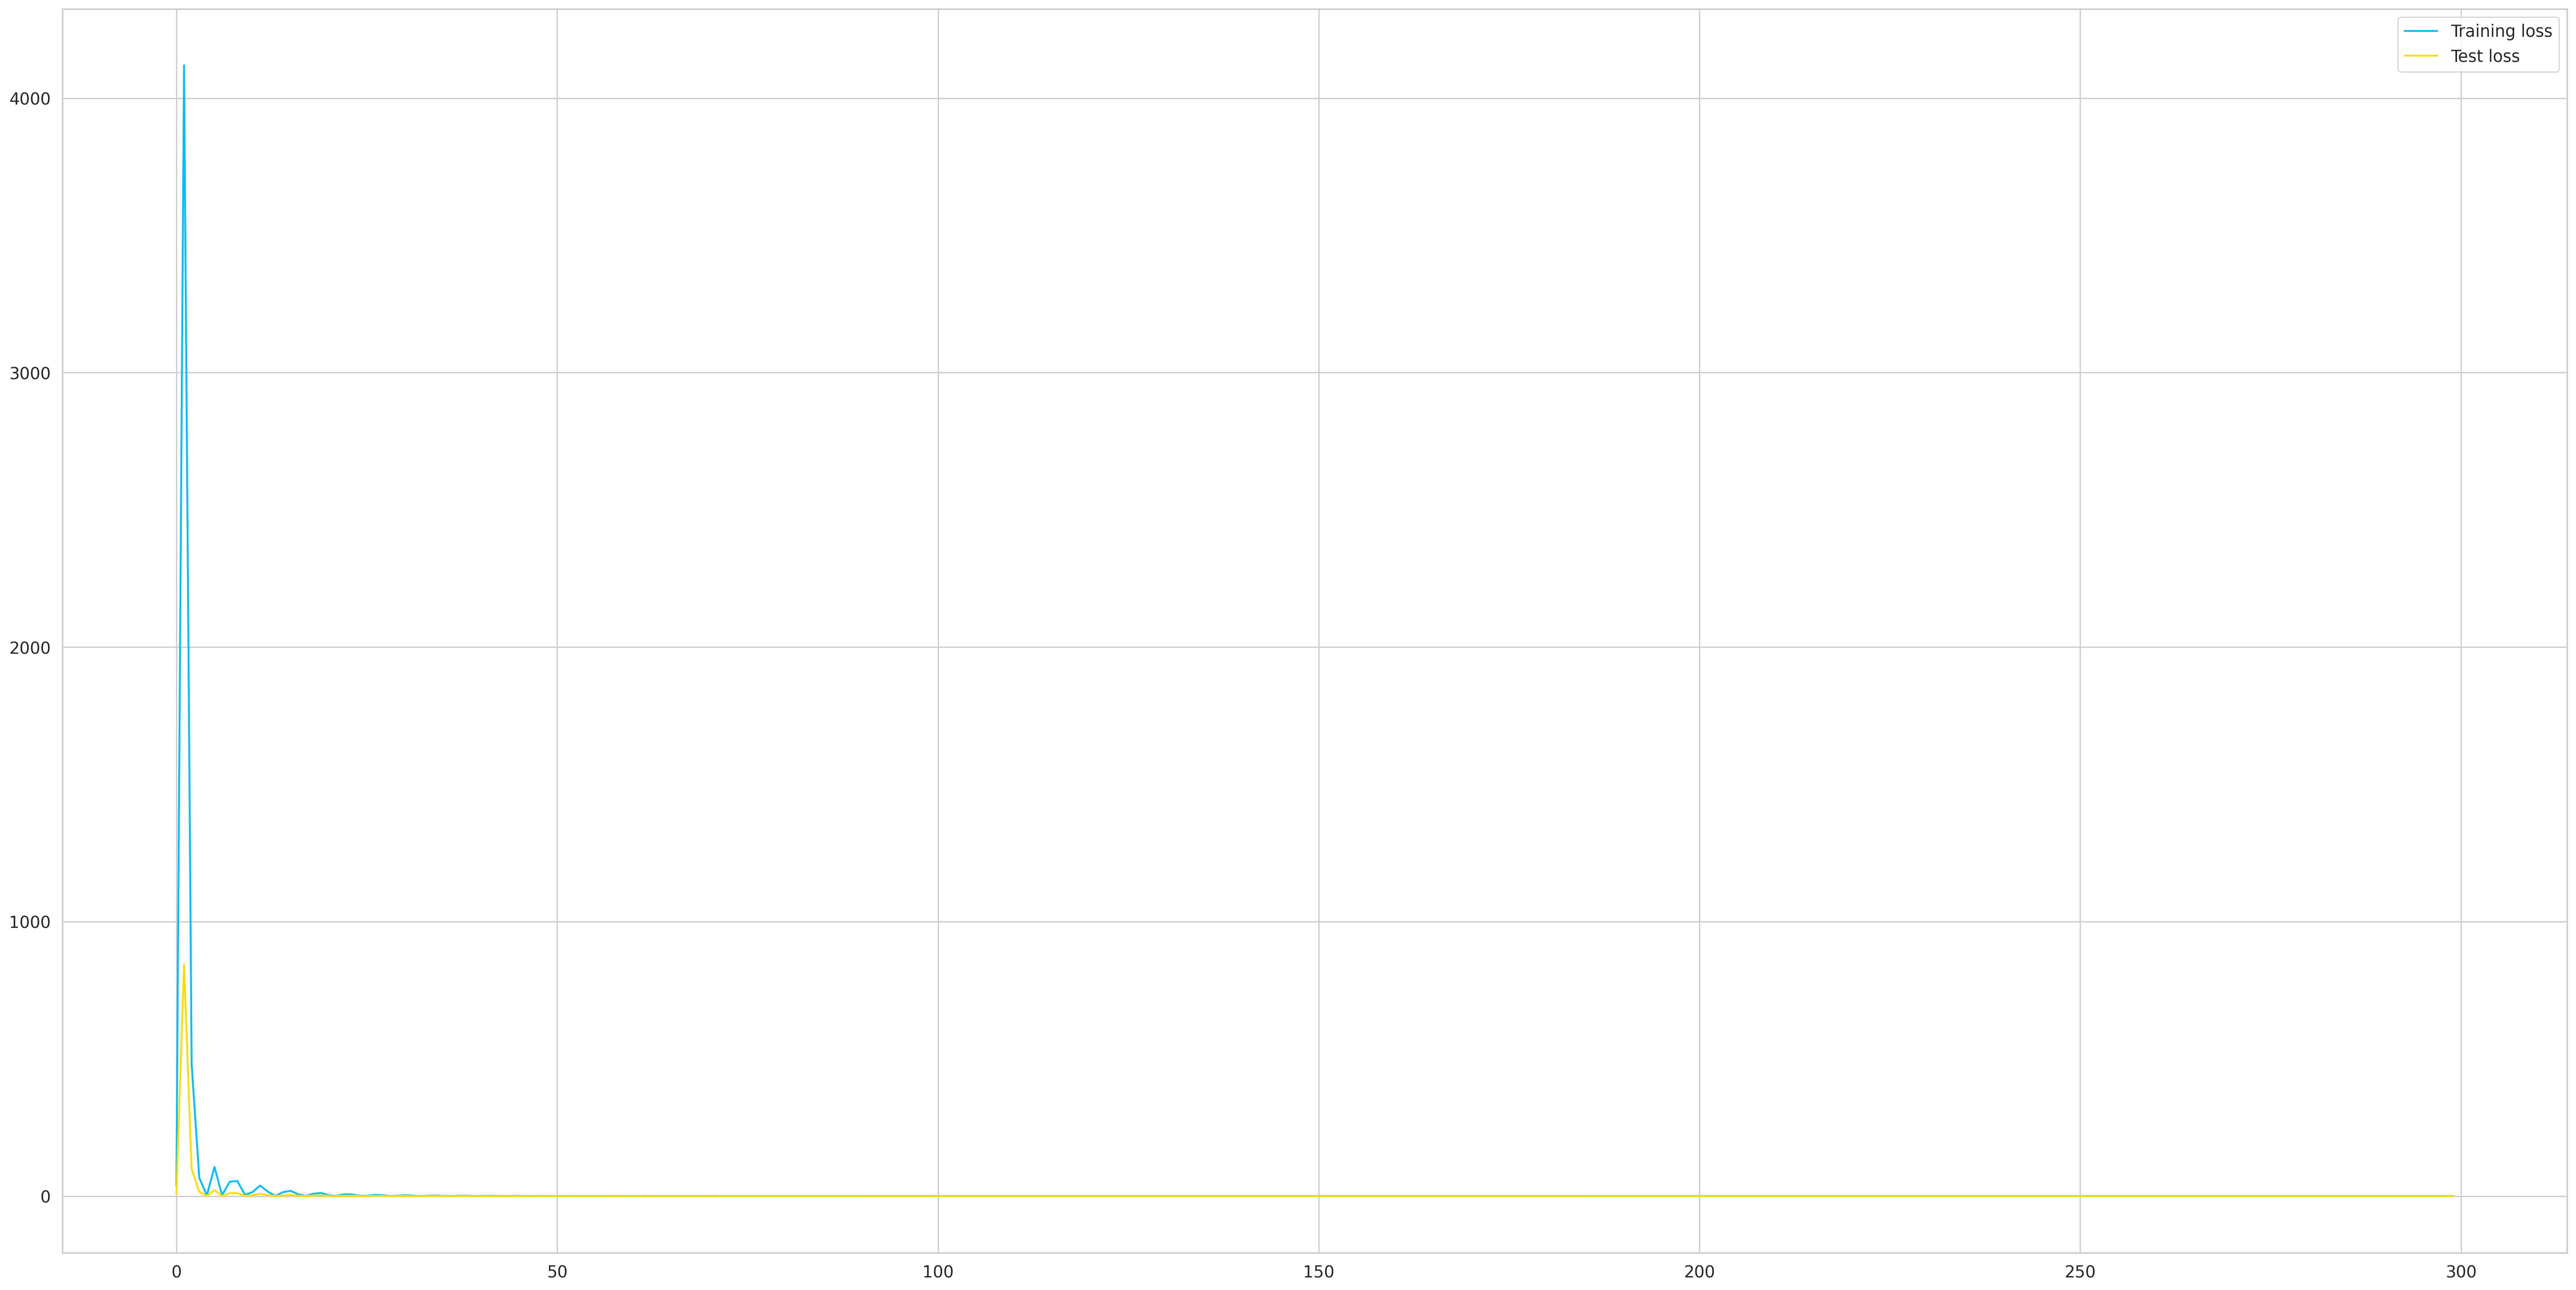

In [25]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
# plt.ylim((0, 5))
plt.legend();

Predicting daily signal


In [26]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [27]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

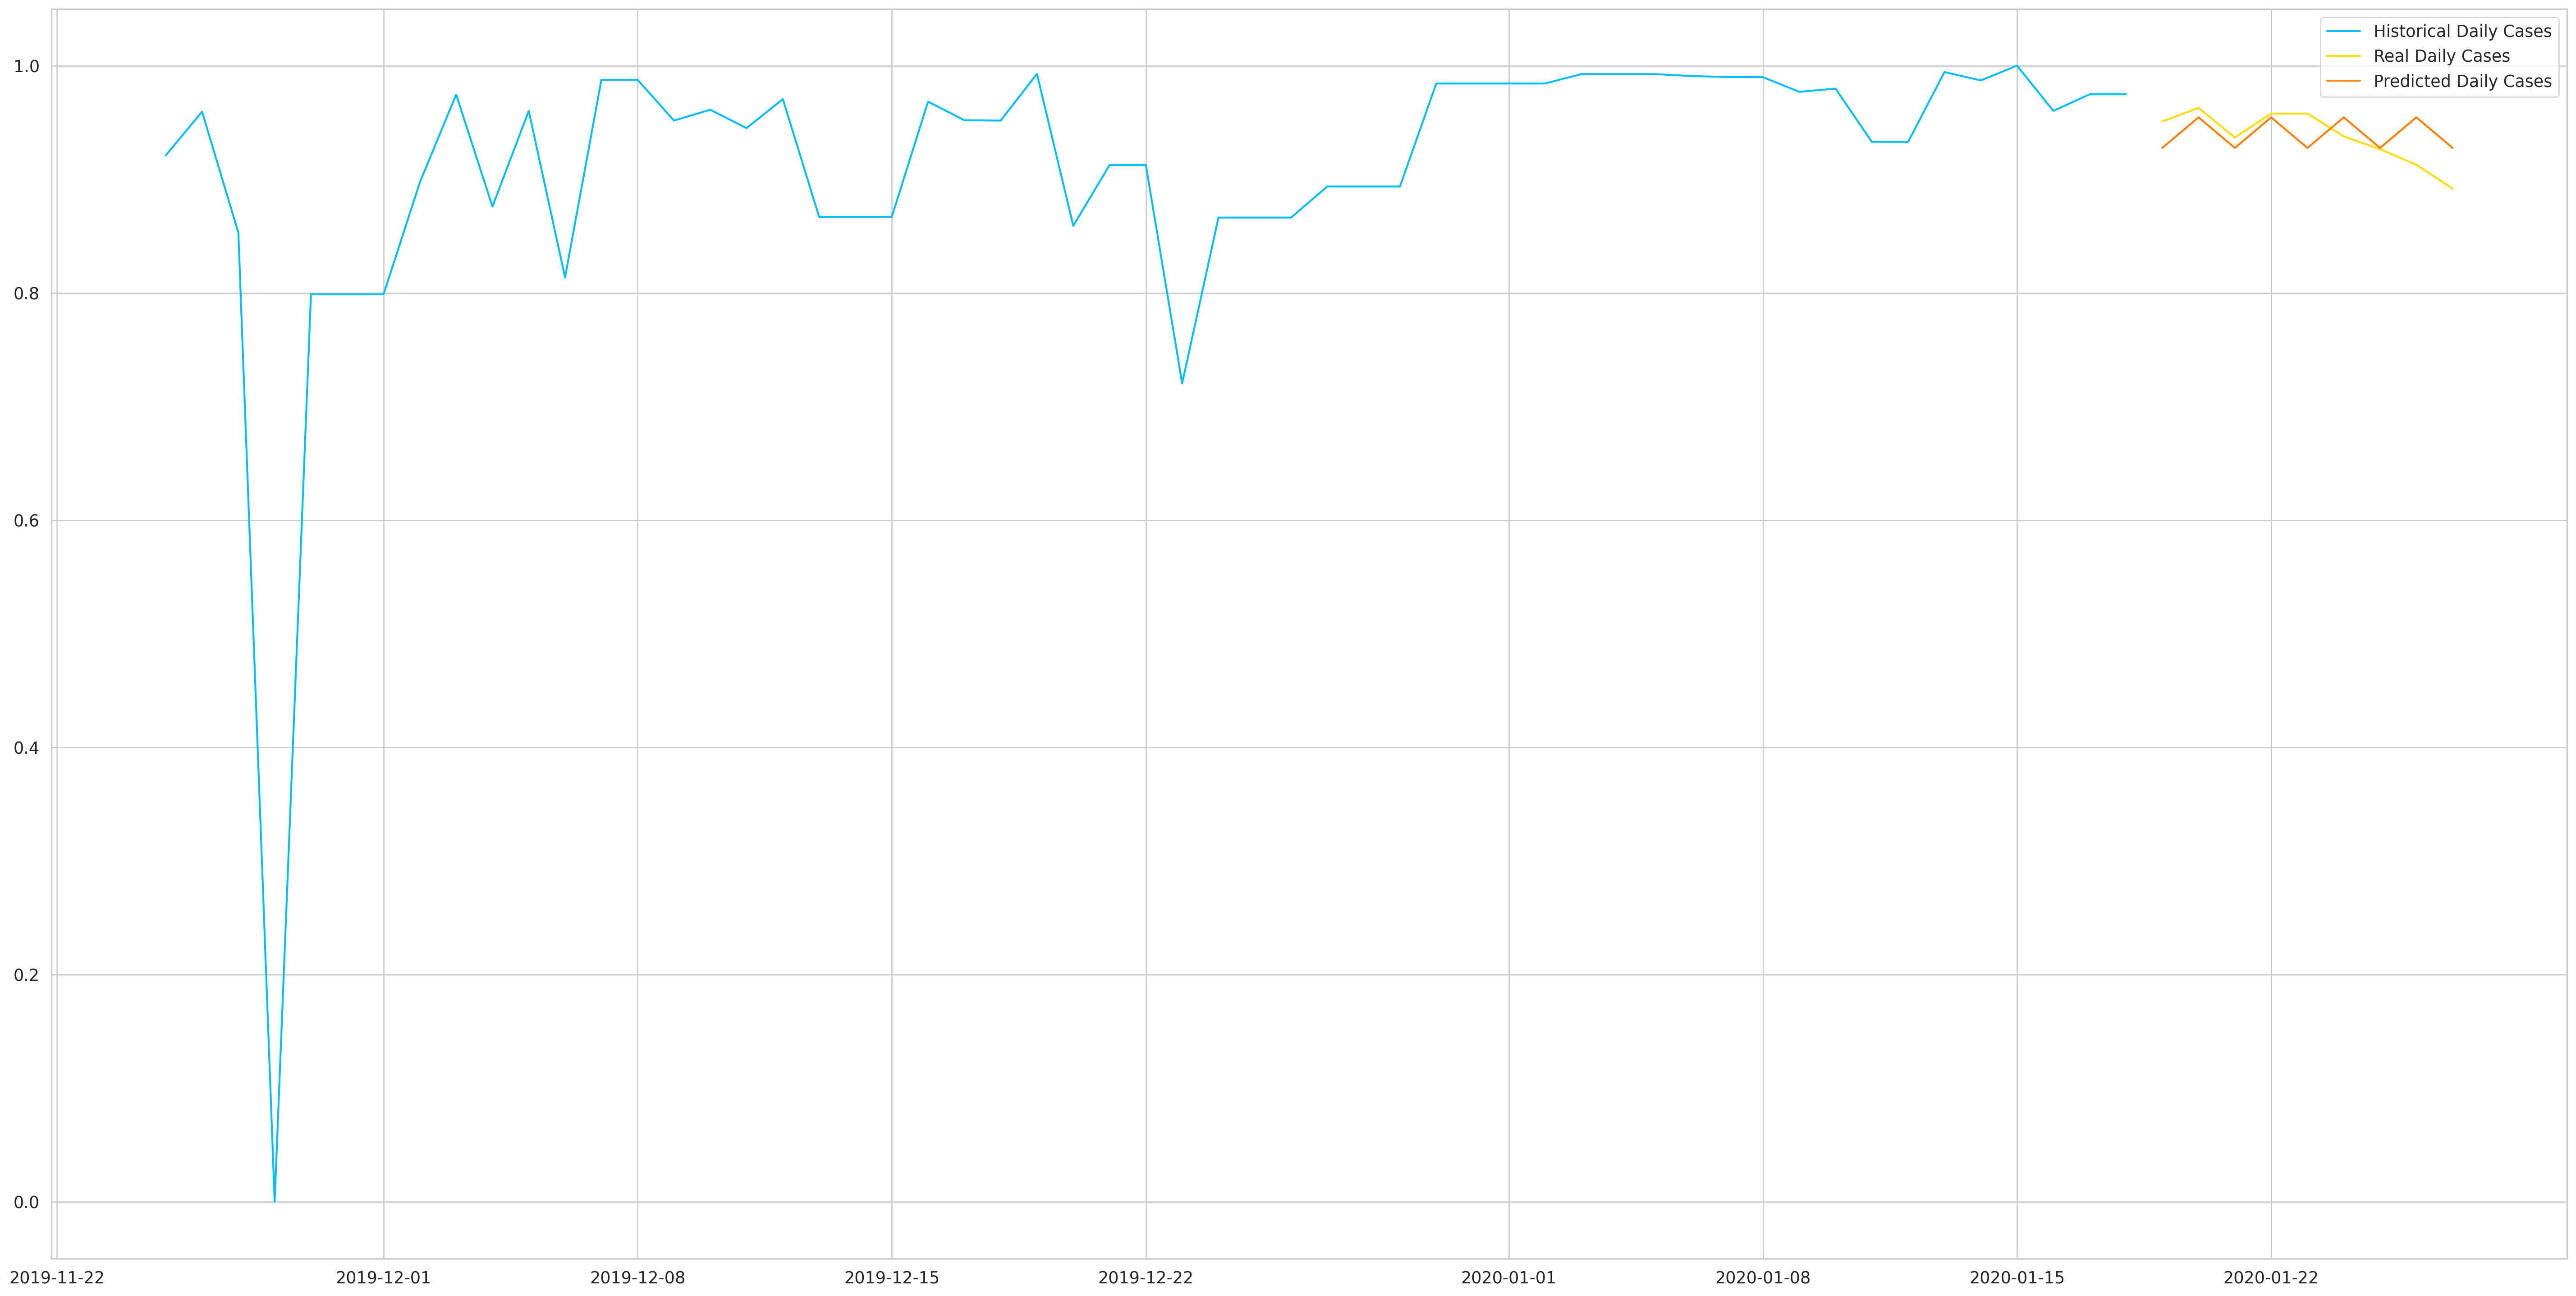

In [28]:
plt.plot(
  df.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  df.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  df.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases'
)

plt.legend();

Use all data for training

In [29]:
scaler = MinMaxScaler()

scaler = scaler.fit(df)

all_data = scaler.transform(df)

all_data.shape
all_data

array([[0.92102205],
       [0.95940934],
       [0.85292338],
       [0.        ],
       [0.79867561],
       [0.79867561],
       [0.79867561],
       [0.89723772],
       [0.9744993 ],
       [0.87594606],
       [0.96020721],
       [0.81347516],
       [0.98748981],
       [0.98748981],
       [0.95164668],
       [0.96117038],
       [0.94501411],
       [0.97052573],
       [0.8668398 ],
       [0.8668398 ],
       [0.8668398 ],
       [0.96829878],
       [0.95194515],
       [0.95161994],
       [0.99275588],
       [0.85898198],
       [0.91249416],
       [0.91249416],
       [0.7203357 ],
       [0.8662523 ],
       [0.8662523 ],
       [0.8662523 ],
       [0.89363718],
       [0.89363718],
       [0.89363718],
       [0.98428039],
       [0.98428039],
       [0.98428039],
       [0.98428039],
       [0.99259006],
       [0.99259006],
       [0.99259006],
       [0.99089572],
       [0.9899753 ],
       [0.98984775],
       [0.97697322],
       [0.97975008],
       [0.932

In [30]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = BatterySignalPredictor(
  n_features=1,
  n_hidden=300,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 40.493499755859375
Epoch 10 train loss: 0.8310849070549011
Epoch 20 train loss: 0.20701655745506287
Epoch 30 train loss: 0.15862534940242767
Epoch 40 train loss: 0.16485346853733063
Epoch 50 train loss: 0.1597244292497635
Epoch 60 train loss: 0.1586216390132904
Epoch 70 train loss: 0.1586722433567047
Epoch 80 train loss: 0.15864714980125427
Epoch 90 train loss: 0.15862415730953217
Epoch 100 train loss: 0.15862272679805756
Epoch 110 train loss: 0.15862588584423065
Epoch 120 train loss: 0.15862275660037994
Epoch 130 train loss: 0.15862159430980682
Epoch 140 train loss: 0.1586216390132904
Epoch 150 train loss: 0.15862147510051727
Epoch 160 train loss: 0.15862147510051727
Epoch 170 train loss: 0.1586214303970337
Epoch 180 train loss: 0.1586214303970337
Epoch 190 train loss: 0.1586214154958725
Epoch 200 train loss: 0.1586214303970337
Epoch 210 train loss: 0.1586213856935501
Epoch 220 train loss: 0.1586214005947113
Epoch 230 train loss: 0.15862134099006653
Epoch 240 train

In [31]:
DAYS_TO_PREDICT = 7

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [32]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [33]:
df.index[-1]

Timestamp('2020-02-07 00:00:00')

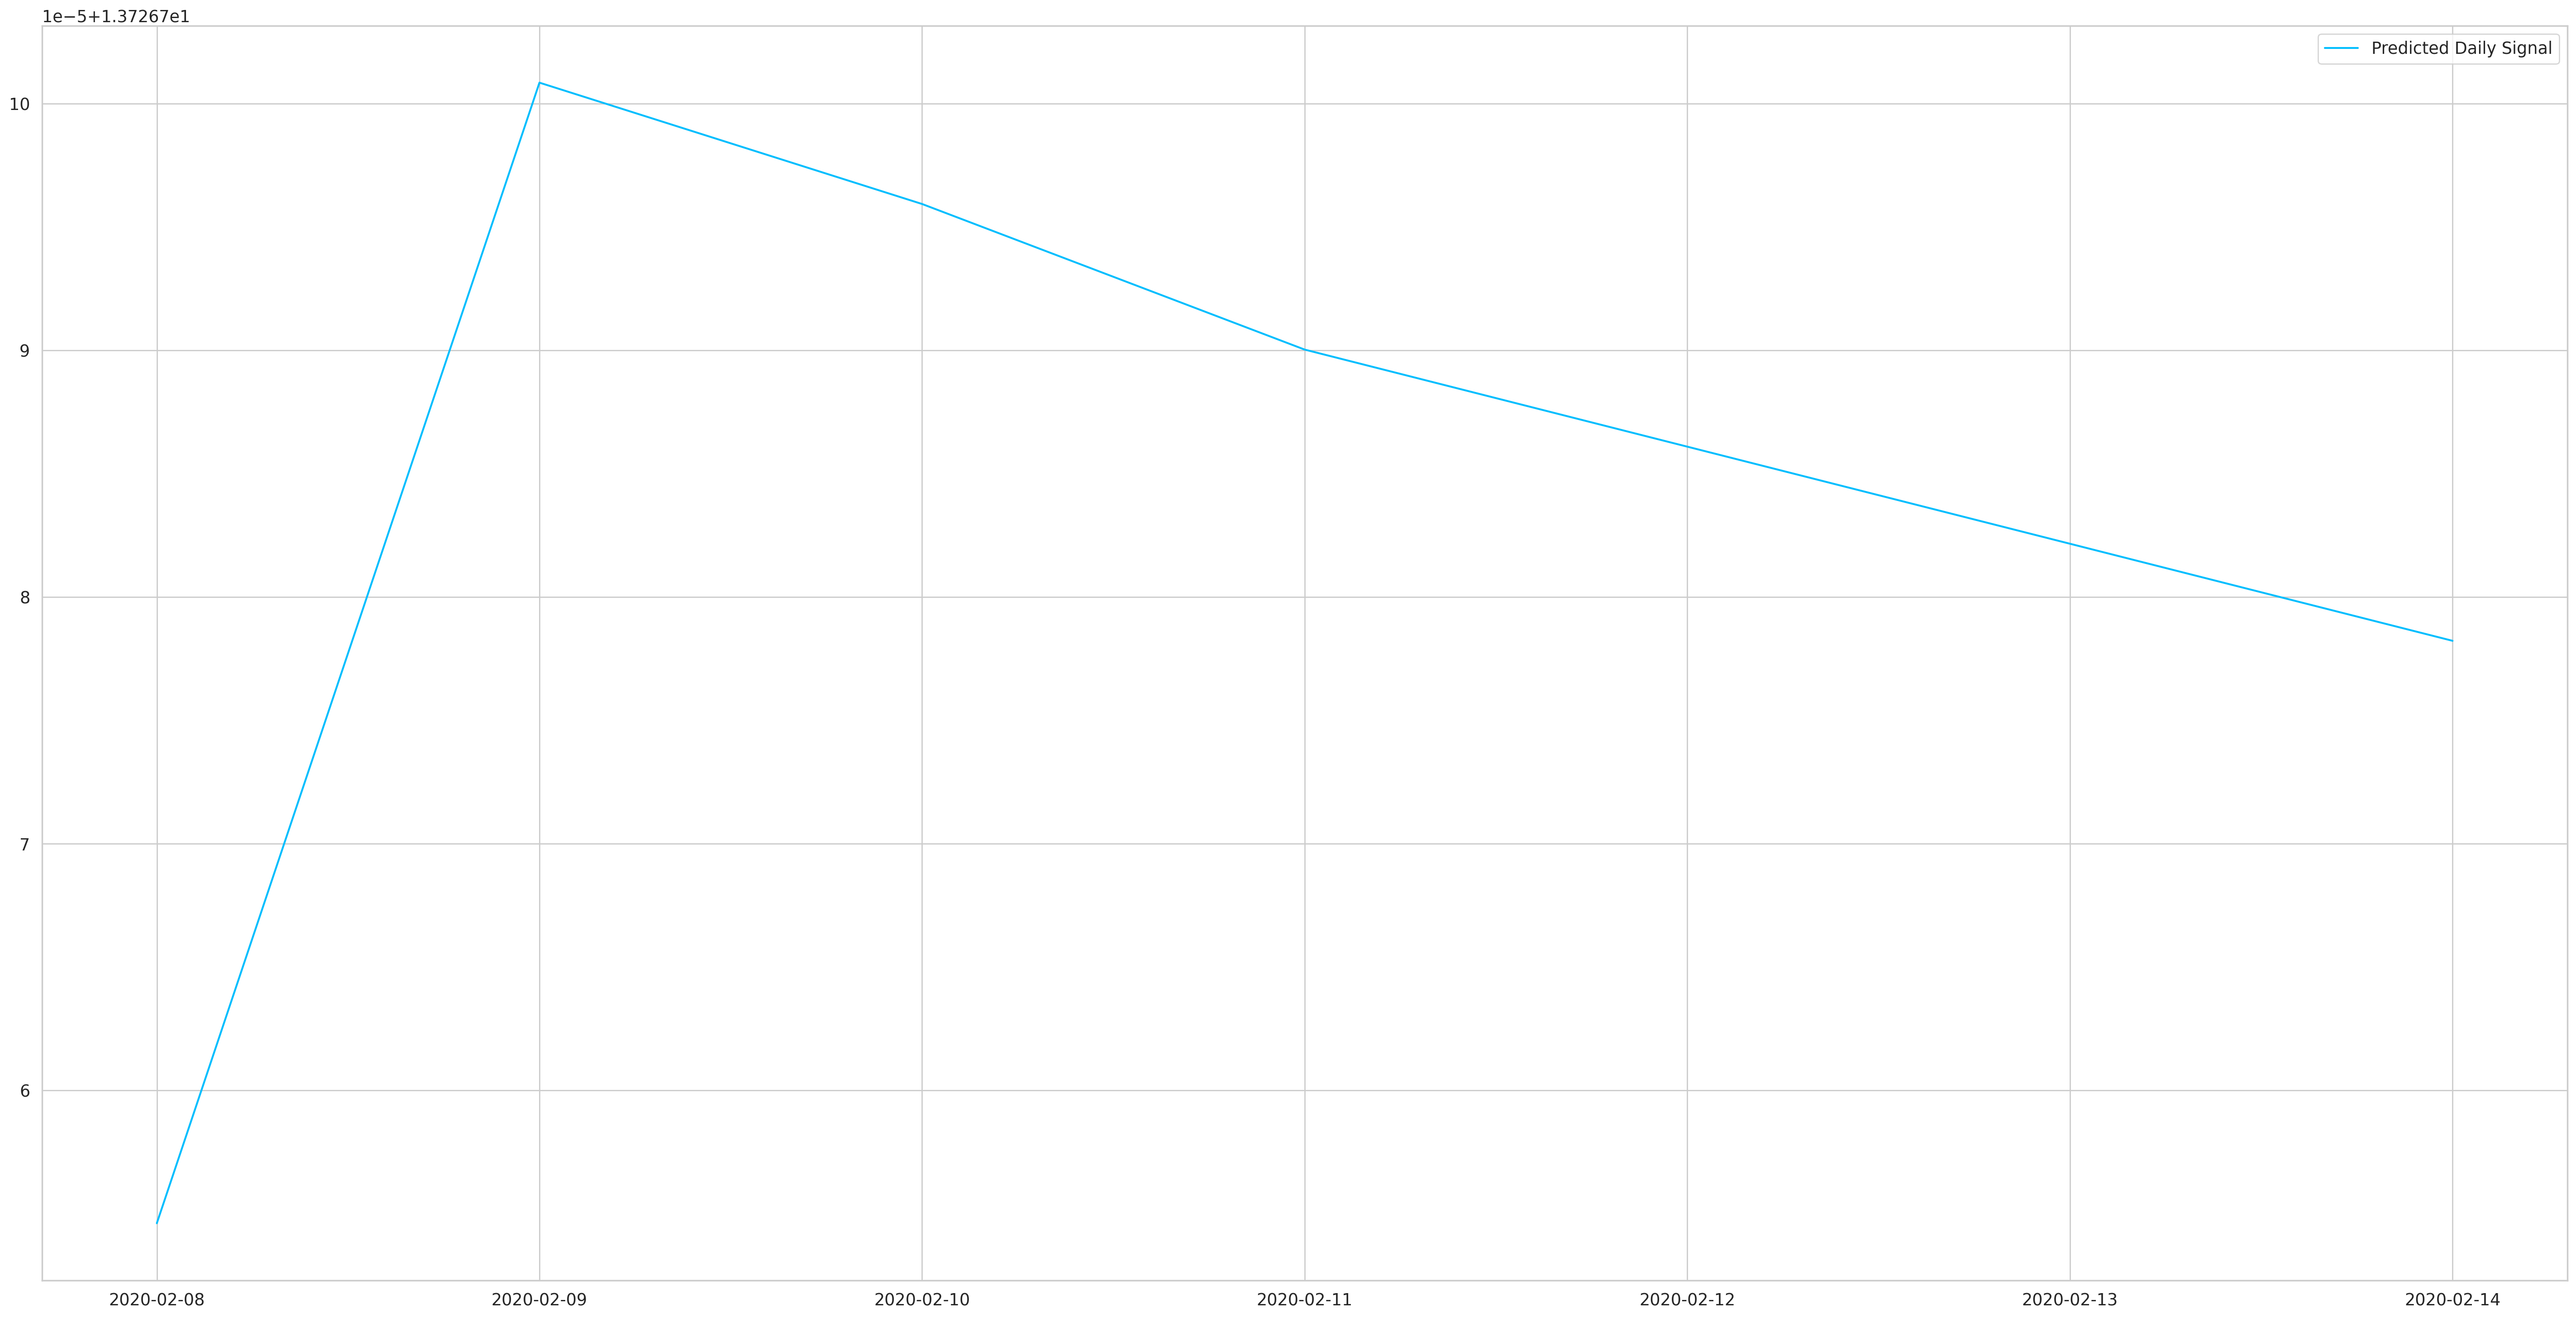

In [35]:
predicted_index = pd.date_range(
    start=df.index[-1],
    periods=DAYS_TO_PREDICT + 1,
    inclusive='right'
)

predicted_cases = pd.Series(
    data=predicted_cases,
    index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Signal')
plt.legend();


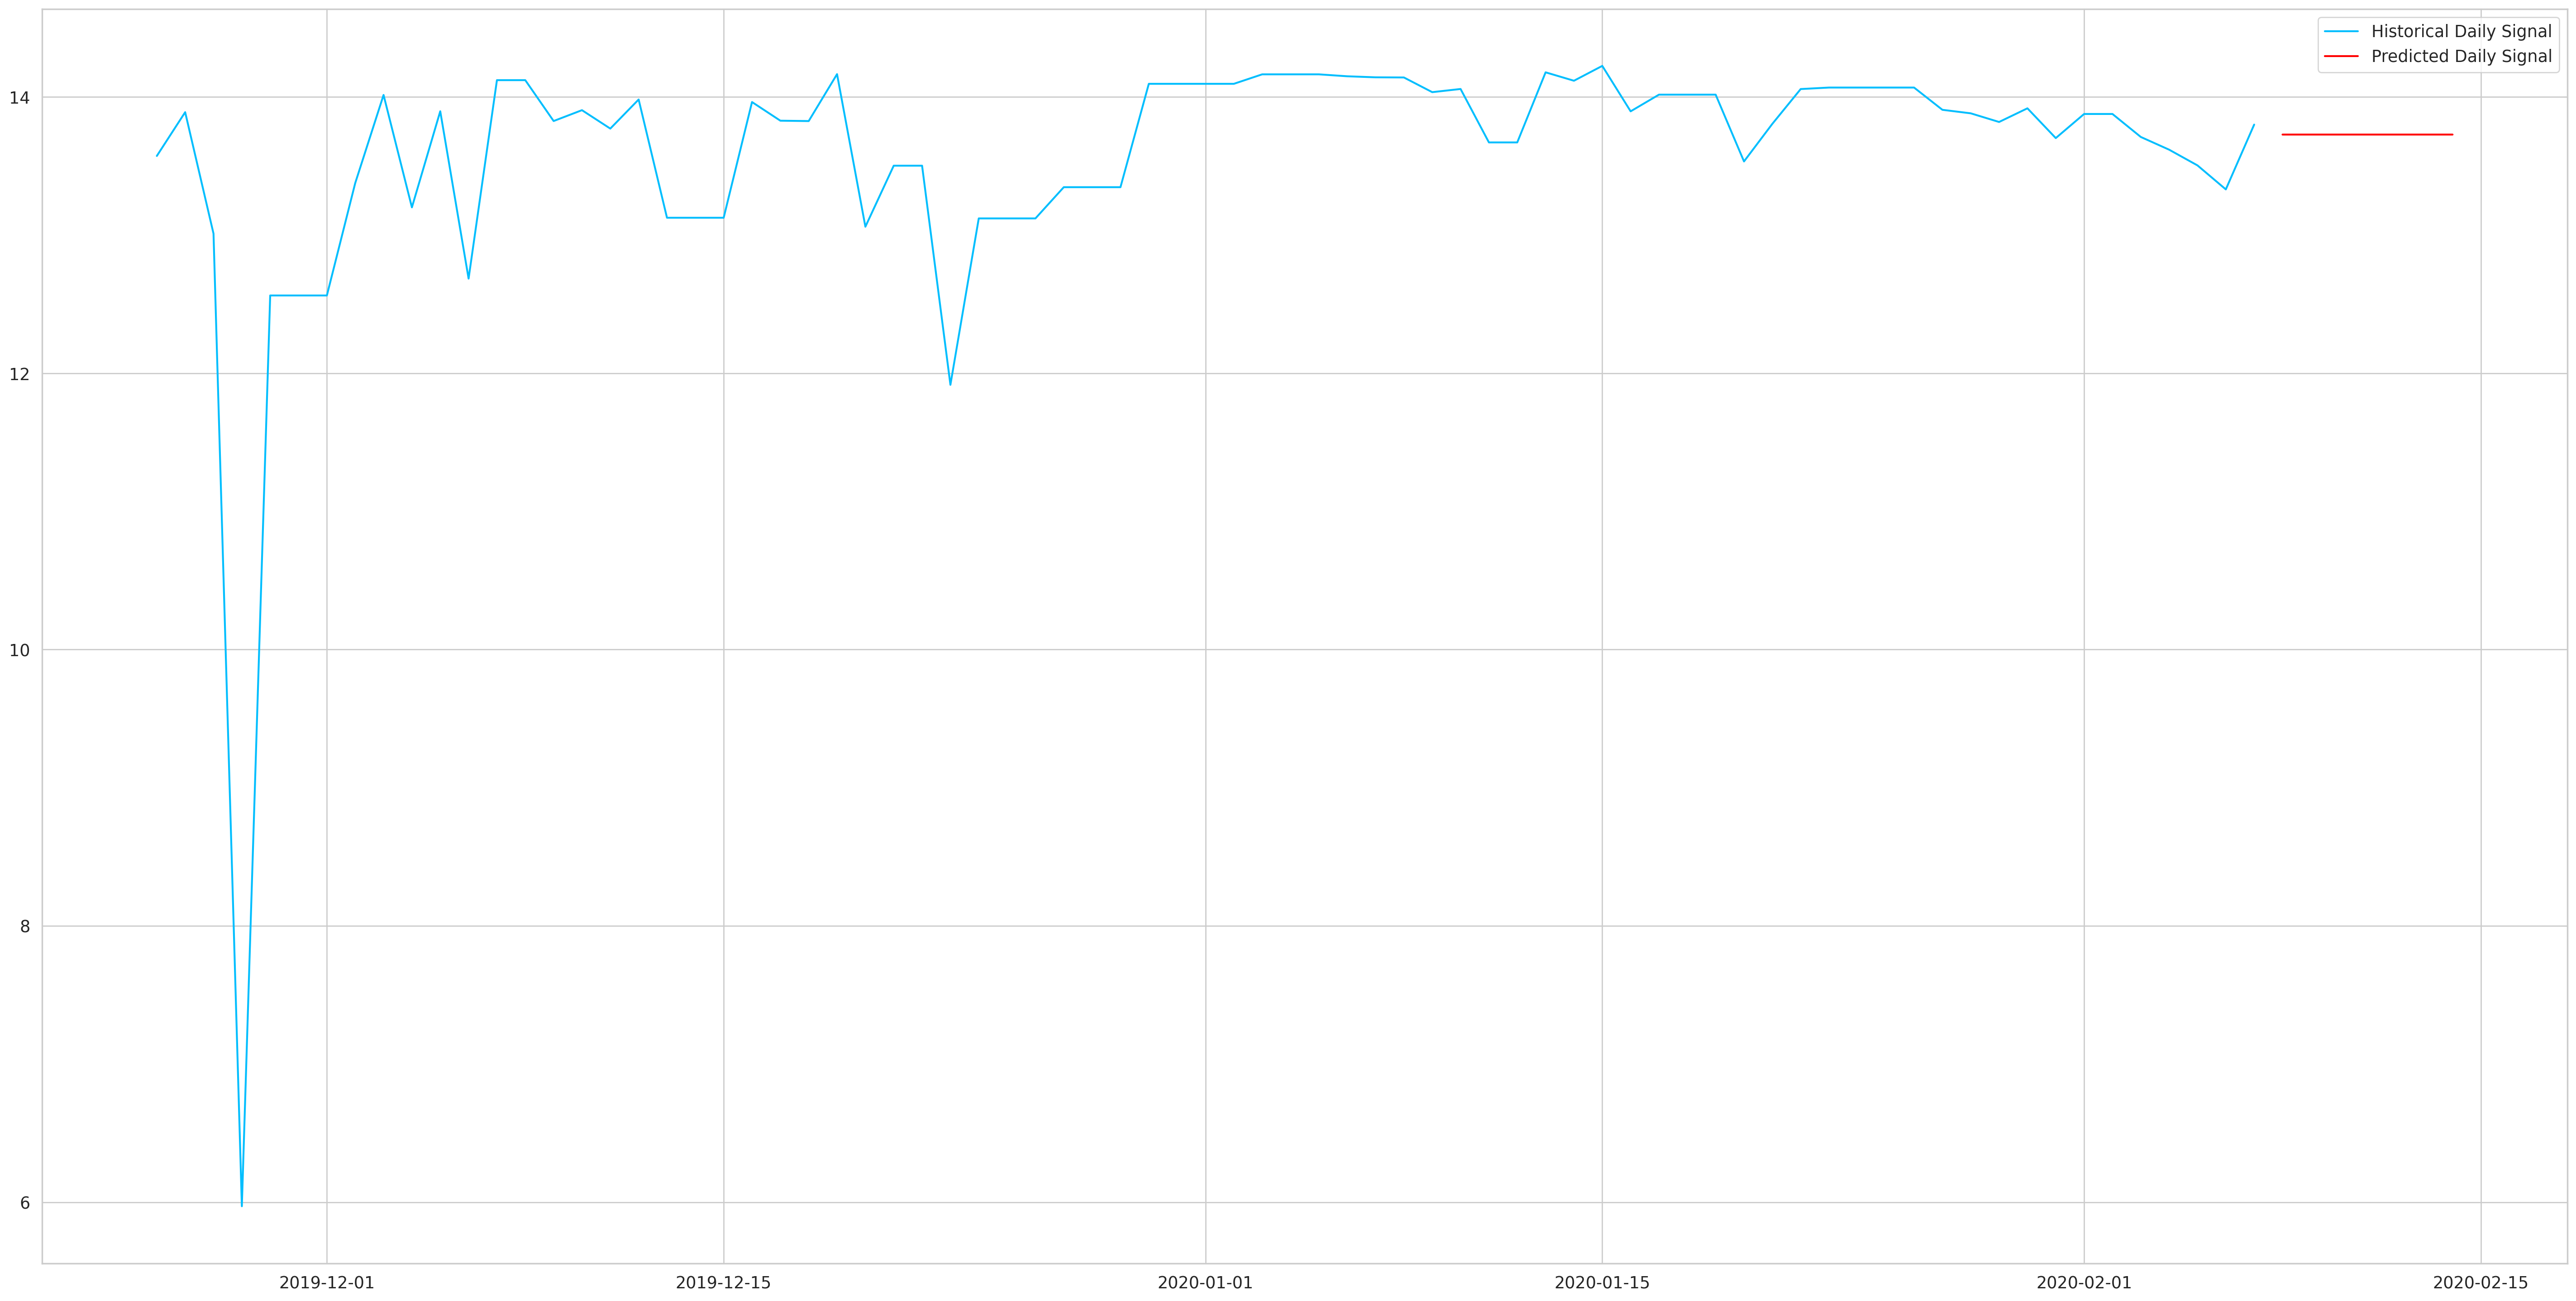

In [36]:
plt.plot(df, label='Historical Daily Signal')
plt.plot(predicted_cases, label='Predicted Daily Signal', color = 'red')
plt.legend();

In [37]:
predicted_cases

,0
2020-02-08,13.726755
2020-02-09,13.726801
2020-02-10,13.726796
2020-02-11,13.726790
2020-02-12,13.726786
2020-02-13,13.726782
2020-02-14,13.726778
